In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install Keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Normalization
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
boston = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/boston.csv')
print(boston.head)

<bound method NDFrame.head of         CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...  ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273   

     PTRATIO       B  LSTAT  PRICE  
0       15.3  396.90   4.98   24.0  
1       17.8  396.9

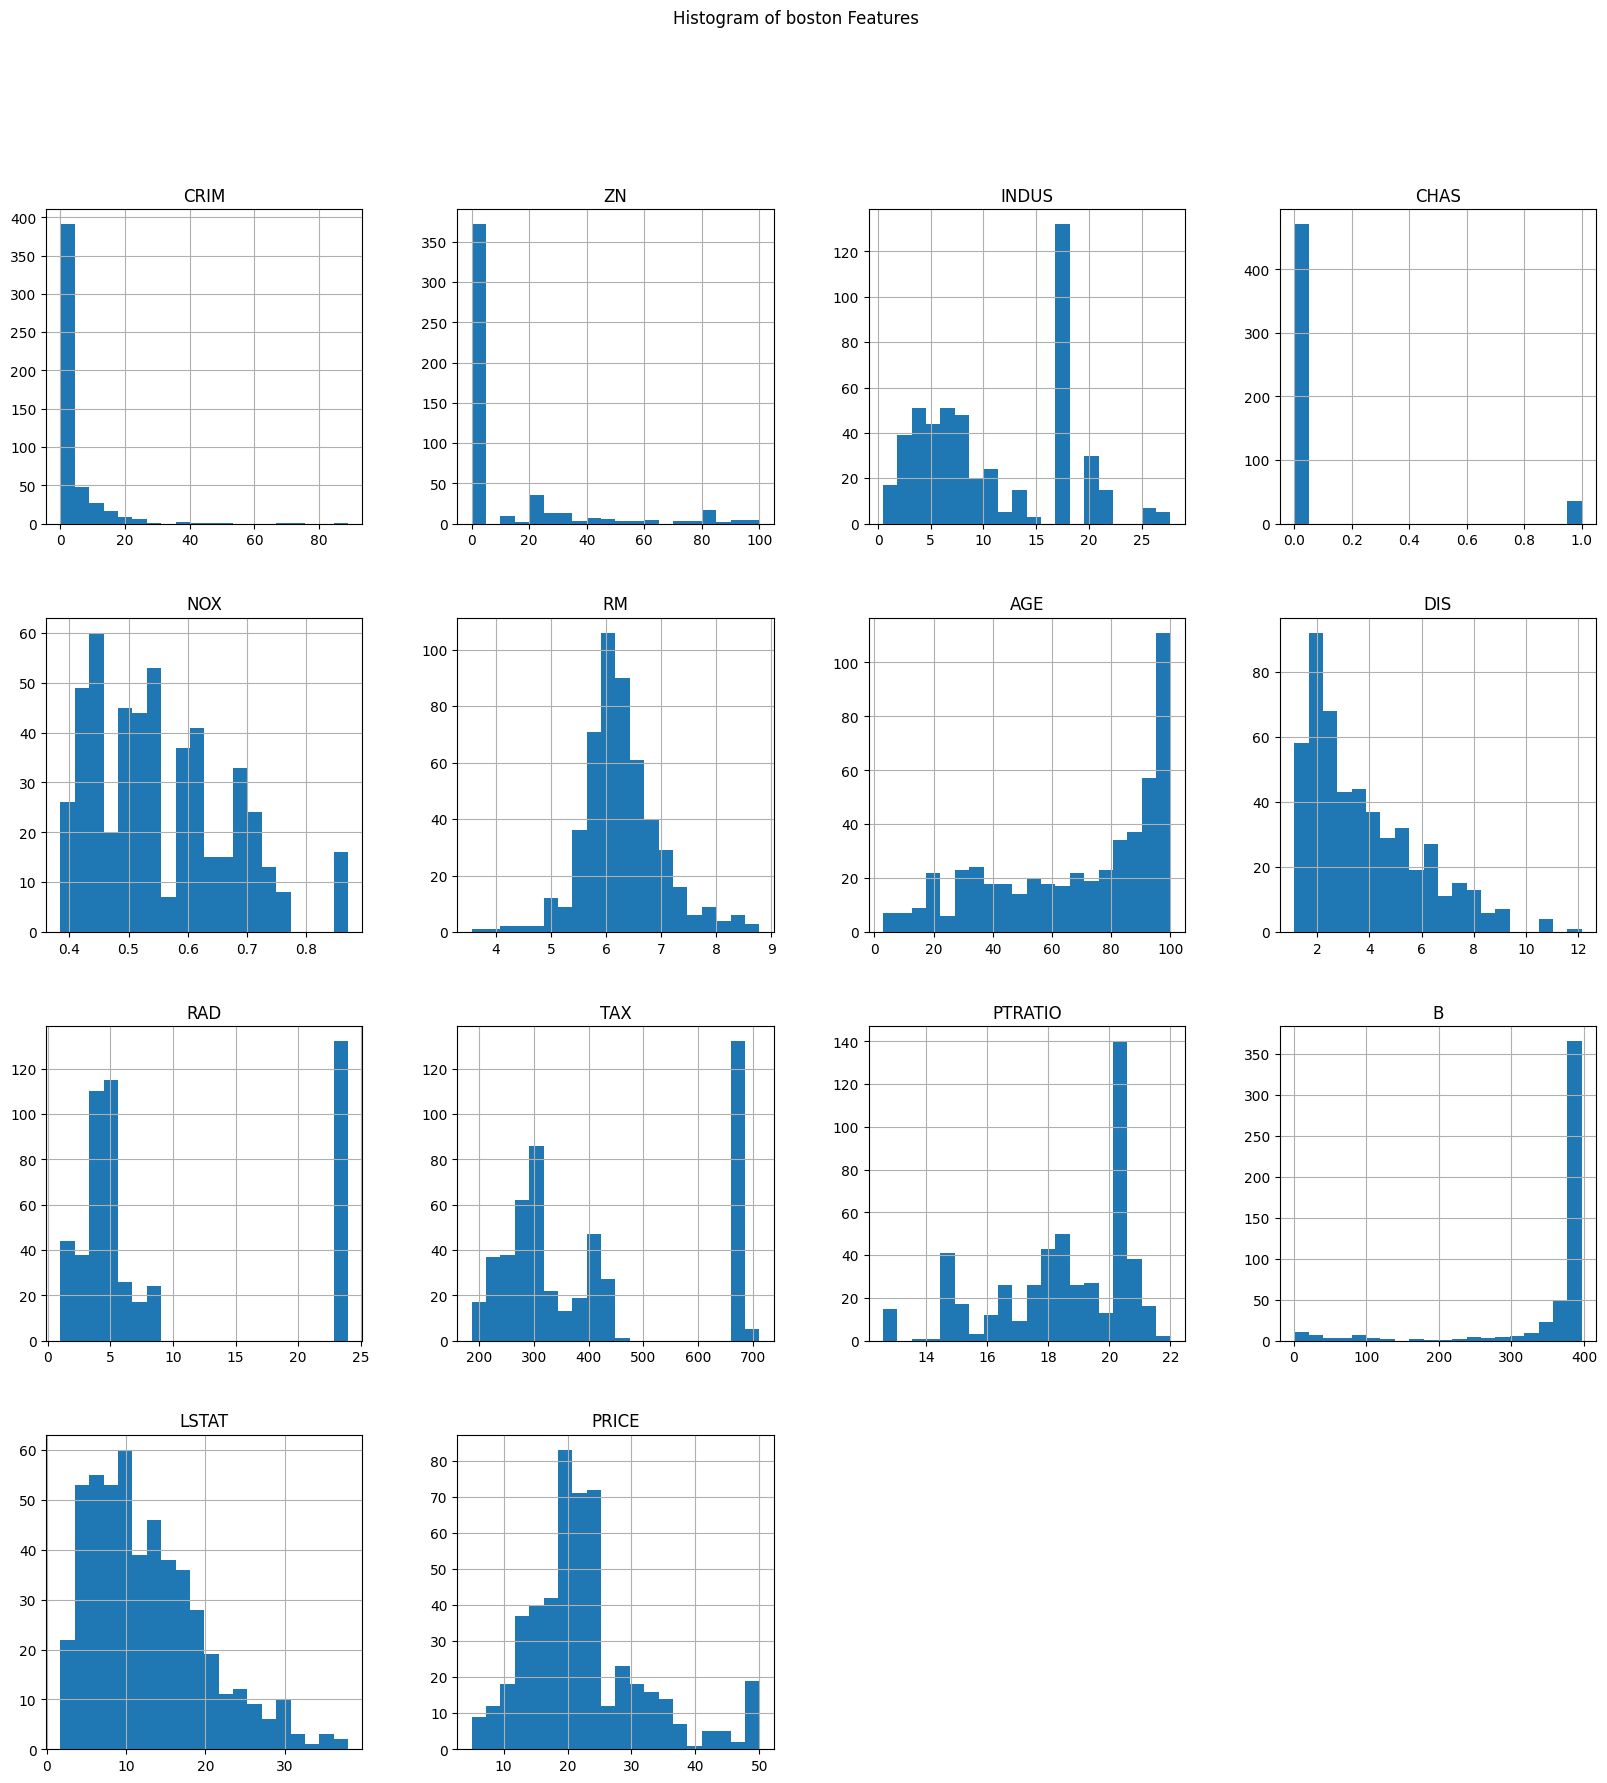

In [ ]:
boston.hist(bins=20, figsize=(20, 20))
plt.suptitle('Histogram of boston Features')
plt.show()

In [ ]:
print(boston.isnull().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64


In [ ]:
boston = boston.sample(frac=1).reset_index(drop=True)

train_length = int(len(boston)*0.8)

xtrain = boston[:train_length]
xtest = boston[train_length:]

validation_lenght = int(len(xtrain)*0.2)

xtrain_proper = xtrain[:validation_lenght]
xvalid = xtrain[validation_lenght:]

ytrain_proper = xtrain_proper.pop('PRICE')
yvalid = xvalid.pop('PRICE')
ytrain = xtrain.pop('PRICE')
ytest = xtest.pop('PRICE')
print(xtrain.shape,xtest.shape)

(404, 13) (102, 13)


In [ ]:
normalizer = Normalization()

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(xtrain.shape[1],)))
    model.add(normalizer)

    learning_rate = hp.Choice('learning_rate',values = [0.00001,0.0001,0.001])
    neurons = hp.Int('neurons',min_value=10,max_value=100,step=10)
    drop_out = hp.Choice('dropout',values = [0.0,0.1,0.2])

    for i in range(hp.Int('layers', min_value=1, max_value=3)):
        model.add(Dense(units=neurons, activation='relu',))
        model.add(Dropout(drop_out))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse',metrics=['mae'])

    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=3,
    directory='best_parameter',
    project_name='diabetes'
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)

tuner.search(xtrain, ytrain, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Trial 20 Complete [00h 00m 45s]
val_mae: 4.796915690104167

Best val_mae So Far: 4.796915690104167
Total elapsed time: 00h 11m 09s


In [ ]:
best_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]
for parameter, value in best_parameters.values.items():
    print(f"{parameter}: {value}")

model = tuner.hypermodel.build(best_parameters)

learning_rate: 0.001
neurons: 50
dropout: 0.0
layers: 1


In [ ]:
class Cross_conformal_predictor:

    def __init__(self,significance,cv_sets,model):
        self.significance = significance
        self.cv_sets = cv_sets
        self.model = model

    def train(self,train_data,train_labels):
        self.train_data = np.array(train_data)
        self.train_labels = np.array(train_labels)


    def quantile(self):
        k = (1-self.significance)*(len(self.train_data)+1)
        return int(np.ceil(k))

    def conf_score(self,calib_data,calib_labels):
        non_confirmity_scores = []
        predictions = self.model.predict(calib_data)
        calib_labels = np.array(calib_labels)
        for i in range(len(predictions)):
            non_confirmity_scores.append(abs(predictions[i][0]-calib_labels[i]))
        return non_confirmity_scores


    def split(self,start,end):

        train_set,train_labels = self.train_data, self.train_labels
        train_set_size = len(train_set)
        calib_set = []
        calib_labels = []
        train_set_proper = []
        train_set_proper_labels = []

        if start==0:
            calib_set = train_set[start:end]
            calib_labels = train_labels[start:end]
            train_set_proper = train_set[end+1:]
            train_set_proper_labels = train_labels[end+1:]
        elif end==len(train_set):
            calib_set = train_set[start:end]
            calib_labels = train_labels[start:end]
            train_set_proper = train_set[:start]
            train_set_proper_labels = train_labels[:start]
        else:
            calib_set = train_set[start:end]
            calib_labels = train_labels[start:end]
            train_set_proper = train_set[:start]
            train_set_proper = np.concatenate([train_set_proper,train_set[end+1:]])
            train_set_proper_labels = train_labels[:start]
            train_set_proper_labels = np.concatenate([train_set_proper_labels,train_labels[end+1:]])

        return train_set_proper,train_set_proper_labels,calib_set,calib_labels


    def predict(self,test_set):
        test_set = np.array(test_set)
        train_set_size = len(self.train_data)

        start = 0
        end = 0

        train_set = []
        train_label = []
        test = []
        predictions = []

        quantile = self.quantile()

        pred = []
        conf = []

        remaining_data_size = train_set_size%self.cv_sets
        remaining_data_count = remaining_data_size

        cv_set_size = train_set_size//self.cv_sets

        early_stop = tf.keras.callbacks.EarlyStopping(monitor='mae',restore_best_weights=True)

        for i in range(1,self.cv_sets+1):

            if remaining_data_count!=0:
                end = start+cv_set_size+1
                train_set_proper,train_set_proper_labels,calib_set,calib_labels = self.split(start,end)
                start = end+1
            elif remaining_data_count==0:
                end = start+cv_set_size
                train_set_proper,train_set_proper_labels,calib_set,calib_labels = self.split(start,end)
                start = end+1

            self.model.fit(train_set_proper,train_set_proper_labels,epochs=30,callbacks=[early_stop])

            non_conf_scores = self.conf_score(calib_set,calib_labels)

            conf += non_conf_scores

        pred = self.model.predict(test_set)

        conf.sort()

        for i in range(len(pred)):
            predictions.append([pred[i][0]-conf[quantile],pred[i][0]+conf[quantile]])

        return predictions

    def error_rate(self,predictions,labels):
        errors = 0
        labels = np.array(labels)
        for i in range(len(labels)):
            if labels[i]>=predictions[i][0] and labels[i]<=predictions[i][1]:
                continue
            else:
                errors += 1
        return errors/len(predictions)



ccp = Cross_conformal_predictor(0.1,5,model)

set_ = []
ccp.train(xtrain,ytrain)
pred = ccp.predict(xtest)
print('error_rate',ccp.error_rate(pred,ytest))
print(pred)
for i in range(len(pred)):
    set_.append(pred[i][1]-pred[i][0])
print('average prediction set size :',np.mean(set_))

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 524.3669 - mae: 17.7513
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 283.7570 - mae: 13.7154 
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 176.1331 - mae: 10.3698 
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126.9595 - mae: 8.5725  
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107.6029 - mae: 7.8810 
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79.2010 - mae: 6.7218 
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.4217 - mae: 6.1216 
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.2863 - mae: 6.2114  
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.8619 - mae: 5.3050 
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70.5267 - mae: 6.4235 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.2732 - mae: 6.0013 
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 46.1291 - mae: 4.8675 
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.1390 - mae: 4.8007 
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.3108 - mae: 5.5923  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.9826 - mae: 4.6150 
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.4986 - mae: 4.7027 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.2507 - mae: 4.8812 
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.2257 - mae: 4.2731 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.9128 - mae: 4.5776 
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.6390 - mae: 4.3813 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.4535 - mae: 4.6334 
Epoch 2/30
9/9 ━━━━

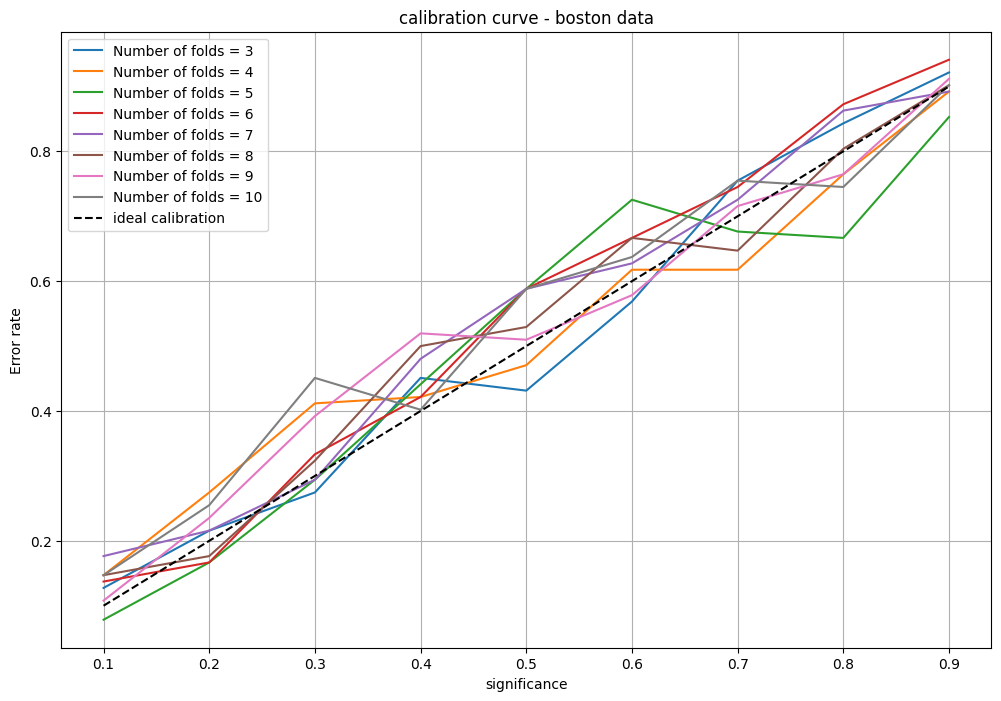

In [ ]:
sig = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cv_sets = [3,4,5,6,7,8,9,10]
fig, ax = plt.subplots(figsize=(12, 8))
for j in range(len(cv_sets)):
    coverage = []
    for i in range(len(sig)):
        ccp = Cross_conformal_predictor(sig[i],cv_sets[j],model)
        ccp.train(xtrain,ytrain)
        pred = ccp.predict(xtest)
        coverage.append(ccp.error_rate(pred,ytest))
    ax.plot(sig,coverage,linestyle='-', label = 'Number of folds = '+str(cv_sets[j]))
    ax.set_xlabel('significance')
    ax.set_ylabel('Error rate')
    ax.set_xticks(sig)
    ax.legend()
plt.plot(sig,sig,linestyle='--',label='ideal calibration',color='black')
plt.title('calibration curve - boston data')
plt.legend()
plt.grid()
plt.savefig('folds-calibrataion.png')
plt.show()

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.9535 - mae: 2.7259 
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9065 - mae: 2.7500
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.3643 - mae: 2.3164
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.6575 - mae: 2.4323
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.7248 - mae: 2.8929 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.6498 - mae: 3.2200 
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.4076 - mae: 2.5897
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.9027 - mae: 2.8714 
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.7576 - mae: 2.4069 
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.3535 - mae: 2.9339 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.4

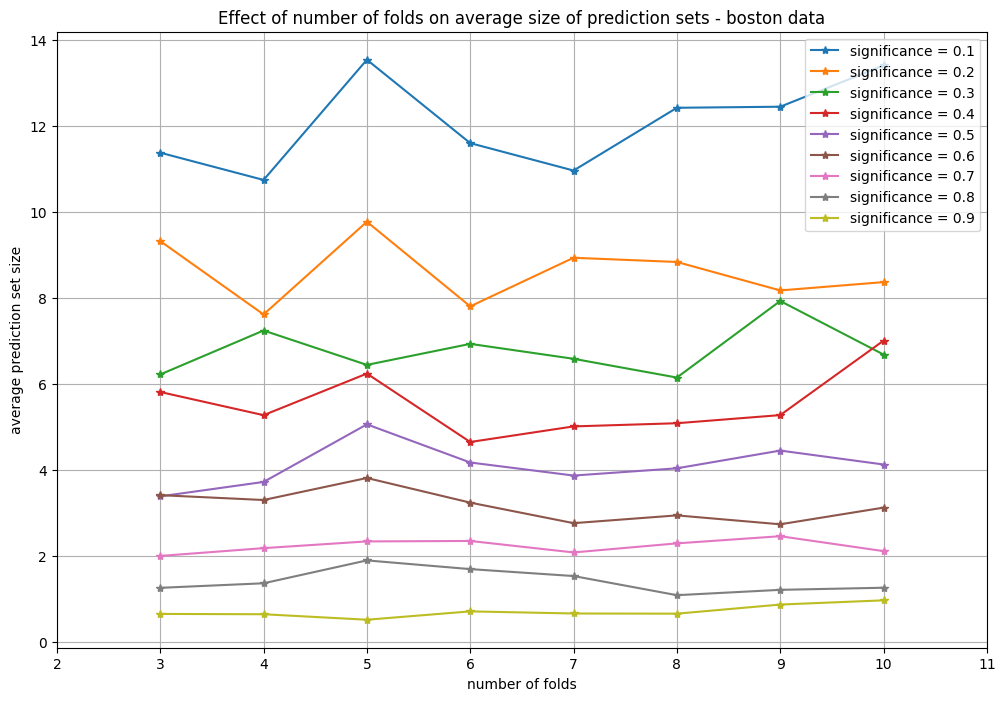

In [ ]:
cv_sets = [3,4,5,6,7,8,9,10]
sig = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(12, 8))

for j in range(len(sig)):
    avg_predset_size = []
    for i in range(len(cv_sets)):
        ccp = Cross_conformal_predictor(sig[j],cv_sets[i],model)
        set_ = []
        ccp.train(xtrain,ytrain)
        pred = ccp.predict(xtest)
        for k in range(len(pred)):
            set_.append(pred[k][1]-pred[k][0])
        avg_predset_size.append(np.mean(set_))
    plt.plot(cv_sets,avg_predset_size, marker='*',linestyle='-', label='significance = '+str(sig[j]))
plt.xlabel('number of folds')
plt.ylabel('average prediction set size')
plt.xticks(range(2,12,1))
plt.xlim(2,11)
plt.legend()
plt.title('Effect of number of folds on average size of prediction sets - boston data')
plt.grid()
plt.savefig('folds_vs_avgpred.png')

plt.show()

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8573 - mae: 2.0383 
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.7308 - mae: 2.4962  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.1189 - mae: 2.5554  
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.4399 - mae: 2.6848
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16.0642 - mae: 2.4309 
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.2628 - mae: 2.3269  
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.4567 - mae: 2.3959  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.6547 - mae: 2.5072
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.0053 - mae: 2.2860
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.0153 - mae: 3.0689
Epoch 2/30
1

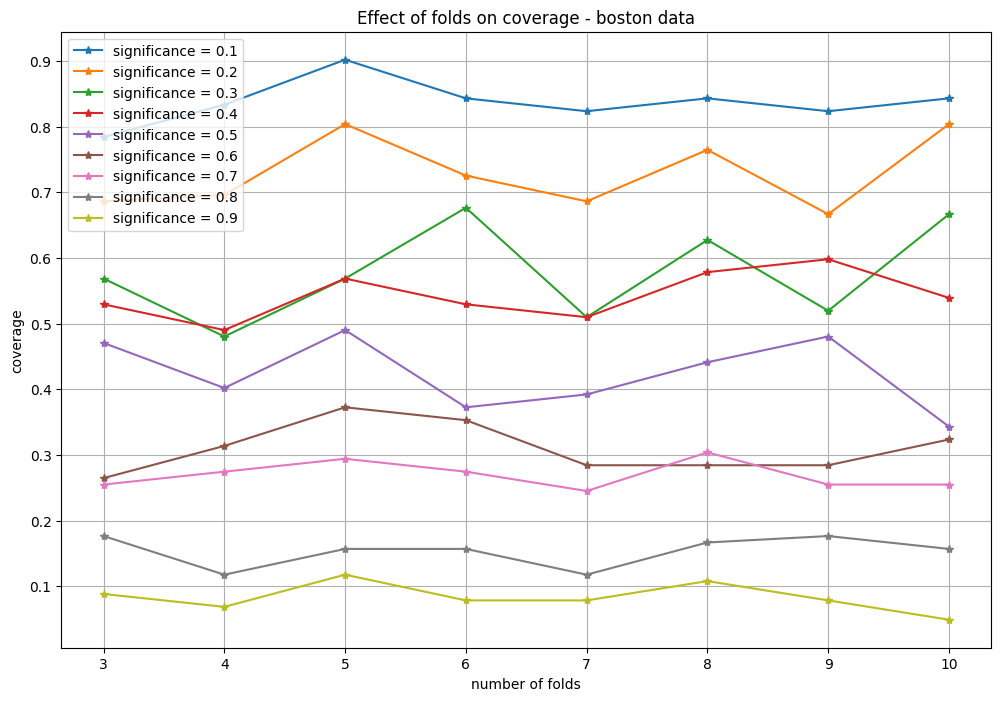

In [ ]:
sig = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cv_sets = [3,4,5,6,7,8,9,10]
fig, ax = plt.subplots(figsize=(12, 8))
for j in range(len(sig)):
    coverage = []
    for i in range(len(cv_sets)):
        ccp = Cross_conformal_predictor(sig[j],cv_sets[i],model)
        ccp.train(xtrain,ytrain)
        pred = ccp.predict(xtest)
        coverage.append(1-ccp.error_rate(pred,ytest))
    ax.plot(cv_sets,coverage, marker='*',linestyle='-', label = 'significance = '+str(sig[j]))
ax.set_xlabel('number of folds')
ax.set_ylabel('coverage')
ax.set_xticks(cv_sets)
ax.set_yticks(sig)
plt.title('Effect of folds on coverage - boston data')
ax.legend()
plt.grid()
plt.savefig('folds-coverage.png')
plt.show()

In [ ]:
class Cross_conformal_predictor:

    def __init__(self,significance,model):
        self.significance = significance
        self.model = model

    def train(self,train_data,train_labels):
        self.train_data = np.array(train_data)
        self.train_labels = np.array(train_labels)


    def quantile_upper_bound(self):
        k = (1-self.significance)*(len(self.train_data)+1)
        return int(np.ceil(k))

    def quantile_lower_bound(self):
        k = self.significance*(len(self.train_data)+1)
        return int(np.floor(k))


    def predict(self,test_set):

        test_set = np.array(test_set)

        train_set_size = len(self.train_data)

        train_set = []
        train_label = []
        test = []
        predictions = []

        quantile_upper = self.quantile_upper_bound()
        quantile_lower = self.quantile_lower_bound()

        pred = []
        residual = 0
        lower_bound = 0
        upper_bound = 0
        test_sample_lower = [[] for _ in range(len(test_set))]
        test_sample_upper = [[] for _ in range(len(test_set))]

        early_stop = tf.keras.callbacks.EarlyStopping(monitor='mae', restore_best_weights=True)

        for j in range(train_set_size):
                    print('train',j)
                    train_set = np.concatenate([self.train_data[:j],self.train_data[j+1:]])
                    train_label = np.concatenate([self.train_labels[:j],self.train_labels[j+1:]])

                    self.model.fit(train_set,train_label,epochs=50,callbacks=[early_stop])

                    train_pred = self.model.predict(np.expand_dims(self.train_data[j], axis=0))

                    pred = self.model.predict(test_set)

                    residual = abs(train_pred[0]-self.train_labels[j]).item()

                    for i in range(len(test_set)):
                        test_sample_lower[i].append(pred[i].item()-residual)
                        test_sample_upper[i].append(pred[i].item()+residual)

        for i in range(len(test_set)):
            test_sample_lower[i] = sorted(test_sample_lower[i])
            test_sample_upper[i] = sorted(test_sample_upper[i])
            lower_bound = test_sample_lower[i][quantile_lower-1]
            upper_bound = test_sample_upper[i][quantile_upper-1]
            predictions.append([lower_bound,upper_bound])

        return predictions

    def error_rate(self,predictions,labels):
        errors = 0
        labels = np.array(labels)
        for i in range(len(labels)):
            if labels[i]>=predictions[i][0] and labels[i]<=predictions[i][1]:
                continue
            else:
                errors += 1
        return errors/len(predictions)



ccp = Cross_conformal_predictor(0.1,model)

set_ = []
# on diabetes dataset
ccp.train(xtrain,ytrain)
pred = ccp.predict(xtest)
print('error_rate',ccp.error_rate(pred,ytest))
print(pred)
for i in range(len(pred)):
    set_.append(pred[i][1]-pred[i][0])
print('average prediction set size :',np.mean(set_))

train 0
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4203 - mae: 2.2304 
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.4829 - mae: 2.4593  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
train 1
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.0649 - mae: 2.6118
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.3230 - mae: 2.2153 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0287 - mae: 2.1730  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
train 2
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5355 - mae: 2.2519  
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.5917 - mae: 2.3128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
train 3
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.7960 - mae: 2.3421 
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7022 - mae: 2.2684 
1/1 ━━━━━━━━━━

Streaming output truncated to the last 5000 lines.
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0253 - mae: 1.6214 
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3350 - mae: 1.6762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
train 99
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0955 - mae: 1.6727
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2673 - mae: 1.6790
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
train 100
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9270 - mae: 1.6642 
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5698 - mae: 1.5097 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
train 101
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9959 - mae: 1.7131 
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0111 - mae: 1.7958
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━

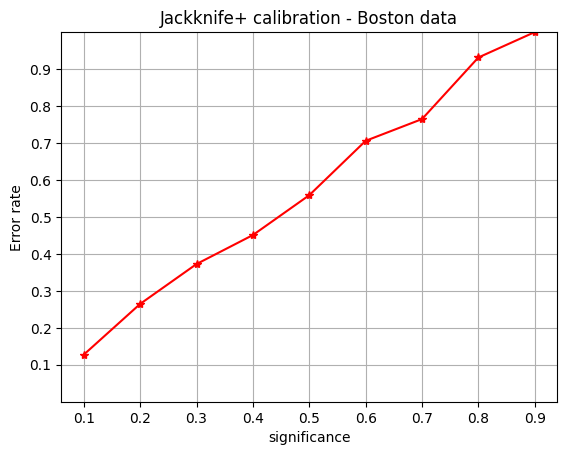

In [15]:
sig = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure()
coverage = []
for i in range(len(sig)):
    ccp = Cross_conformal_predictor(sig[i],model)
    ccp.train(xtrain,ytrain)
    pred = ccp.predict(xtest)
    coverage.append(ccp.error_rate(pred,ytest))

plt.plot(sig,coverage, marker='*',linestyle='-', color='red')
plt.xlabel('significance')
plt.ylabel('Error rate')
plt.yticks(sig)
plt.ylim(0,1)
plt.title('Jackknife+ calibration - Boston data')
plt.grid()
plt.savefig('Jackknife+-calibration.png')
plt.show()

In [16]:
class ICP:

    def __init__(self,significance,model):
        self.significance = significance
        self.model = model

    def train(self,train_data,train_labels):
        self.train_data = np.array(train_data)
        self.train_labels = np.array(train_labels)

    def conf_score(self,calib_data,calib_labels):
        non_confirmity_scores = []
        predictions = self.model.predict(calib_data)
        calib_labels = np.array(calib_labels)  # Ensure calib_labels is a NumPy array
        for i in range(len(predictions)):
            non_confirmity_scores.append(abs(predictions[i][0]-calib_labels[i]))
        non_confirmity_scores.sort()
        return non_confirmity_scores

    def predict(self,test_set):

        test_set = np.array(test_set)

        predictions = []

        k = int(np.ceil((1-self.significance)*(len(self.train_data)+1)))

        trainset_proper_length = int(len(self.train_data)*0.75)

        trainset_proper = self.train_data[:trainset_proper_length]
        trainset_labels = self.train_labels[:trainset_proper_length]
        calib_data = self.train_data[trainset_proper_length:]
        calib_labels = self.train_labels[trainset_proper_length:]

        k = int(np.ceil((1-self.significance)*(len(calib_data)+1)))

        early_stop = tf.keras.callbacks.EarlyStopping(monitor='mae',restore_best_weights=True)

        self.model.fit(trainset_proper,trainset_labels,epochs = 30, callbacks = [early_stop])

        conf_score = self.conf_score(calib_data,calib_labels)

        pred = self.model.predict(test_set)

        for i in range(len(test_set)):

            predictions.append([pred[i].item()-conf_score[k-1],pred[i].item()+conf_score[k-1]])

        return predictions

    def error_rate(self,predictions,labels):
        errors = 0
        labels = np.array(labels)
        for i in range(len(labels)):
            if labels[i]>=predictions[i][0] and labels[i]<=predictions[i][1]:
                continue
            else:
                errors += 1
        return errors/len(predictions)


ccp = ICP(0.1,model)

ccp.train(xtrain,ytrain)
pred = ccp.predict(xtest)
print('error_rate',ccp.error_rate(pred,ytest))
print(pred)

print(pred[i][1]-pred[i][0])

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3625 - mae: 1.7385
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2360 - mae: 1.6390
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6749 - mae: 1.5463
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
92 101
error_rate 0.2549019607843137
[[19.471738433837892, 26.522611999511717], [41.58238563537598, 48.6332592010498], [14.97794303894043, 22.028816604614256], [18.505120849609376, 25.5559944152832], [18.510058975219728, 25.560932540893553], [21.176820373535158, 28.227693939208983], [17.588180160522462, 24.639053726196288], [21.45922431945801, 28.510097885131835], [20.965690231323244, 28.01656379699707], [15.889148330688476, 22.940021896362303], [22.09468994140625, 29.145563507080077], [15.853568649291992, 22.90444221496582], [21.290534591674806, 28.34140815734863], [11.600665664672851, 18.65153923034668], [14.268134689331054, 21.31900825500488], [23.57797203063965, 30.62884

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1711 - mae: 1.7087  
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1970 - mae: 1.5805  
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3512 - mae: 1.5689  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
92 101
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0833 - mae: 1.5117 
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2613 - mae: 1.5280 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
82 101
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3260 - mae: 1.7834 
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0740 - mae: 1.5256 
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4258 - mae: 1.7225 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
72 101
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1492 - mae: 1.7127 
Epoch 2/30
10/10 ━━━━━━━━━━━

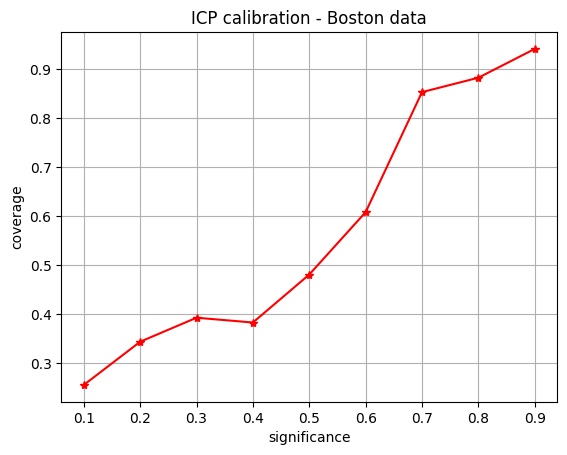

In [19]:
sig = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure()
coverage = []
for i in range(len(sig)):
    icp = ICP(sig[i],model)
    icp.train(xtrain,ytrain)
    pred = icp.predict(xtest)
    coverage.append(icp.error_rate(pred,ytest))

plt.plot(sig,coverage, marker='*',linestyle='-', color='red')
plt.xlabel('significance')
plt.ylabel('coverage')
plt.grid()
plt.title('ICP calibration - Boston data')
plt.savefig('icp_calib.png')
plt.show()

In [20]:
# LR

from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [21]:
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

In [22]:
model = LinearRegression()

In [23]:
class Cross_conformal_predictor:

    def __init__(self,significance,cv_sets,model):
        self.significance = significance
        self.cv_sets = cv_sets
        self.model = model

    def train(self,train_data,train_labels):
        self.train_data = np.array(train_data)
        self.train_labels = np.array(train_labels)


    def quantile(self):
        k = (1-self.significance)*(len(self.train_data)+1)
        return int(np.ceil(k))

    def conf_score(self,calib_data,calib_labels):
        non_confirmity_scores = []
        predictions = self.model.predict(calib_data)
        calib_labels = np.array(calib_labels)
        for i in range(len(predictions)):
            non_confirmity_scores.append(abs(predictions[i]-calib_labels[i]))
        return non_confirmity_scores


    def split(self,start,end):

        train_set,train_labels = self.train_data, self.train_labels
        train_set_size = len(train_set)
        calib_set = []
        calib_labels = []
        train_set_proper = []
        train_set_proper_labels = []

        if start==0:
            calib_set = train_set[start:end]
            calib_labels = train_labels[start:end]
            train_set_proper = train_set[end+1:]
            train_set_proper_labels = train_labels[end+1:]
        elif end==len(train_set):
            calib_set = train_set[start:end]
            calib_labels = train_labels[start:end]
            train_set_proper = train_set[:start]
            train_set_proper_labels = train_labels[:start]
        else:
            calib_set = train_set[start:end]
            calib_labels = train_labels[start:end]
            train_set_proper = train_set[:start]
            train_set_proper = np.concatenate([train_set_proper,train_set[end+1:]])
            train_set_proper_labels = train_labels[:start]
            train_set_proper_labels = np.concatenate([train_set_proper_labels,train_labels[end+1:]])

        return train_set_proper,train_set_proper_labels,calib_set,calib_labels


    def predict(self,test_set):
        test_set = np.array(test_set)
        train_set_size = len(self.train_data)

        start = 0
        end = 0

        train_set = []
        train_label = []
        test = []
        predictions = []

        quantile = self.quantile()

        pred = []
        conf = []

        remaining_data_size = train_set_size%self.cv_sets
        remaining_data_count = remaining_data_size

        cv_set_size = train_set_size//self.cv_sets


        for i in range(1,self.cv_sets+1):

            if remaining_data_count!=0:
                end = start+cv_set_size+1
                train_set_proper,train_set_proper_labels,calib_set,calib_labels = self.split(start,end)
                start = end+1
            elif remaining_data_count==0:
                end = start+cv_set_size
                train_set_proper,train_set_proper_labels,calib_set,calib_labels = self.split(start,end)
                start = end+1

            self.model.fit(train_set_proper,train_set_proper_labels)

            non_conf_scores = self.conf_score(calib_set,calib_labels)

            conf += non_conf_scores

        pred = self.model.predict(test_set)

        conf.sort()

        for i in range(len(pred)):
            predictions.append([pred[i]-conf[quantile-1],pred[i]+conf[quantile-1]])
        return predictions

    def error_rate(self,predictions,labels):
        errors = 0
        labels = np.array(labels)
        for i in range(len(labels)):
            if labels[i]>=predictions[i][0] and labels[i]<=predictions[i][1]:
                continue
            else:
                errors += 1
        return errors/len(predictions)



ccp = Cross_conformal_predictor(0.1,5,model)

set_ = []
ccp.train(xtrain,ytrain)
pred = ccp.predict(xtest)
print('error_rate',ccp.error_rate(pred,ytest))
print(pred)
for i in range(len(pred)):
    set_.append(pred[i][1]-pred[i][0])
print('average prediction set size :',np.mean(set_))

error_rate 0.13725490196078433
[[13.29662056424538, 27.273137597190534], [33.73587360462661, 47.712390637571765], [6.5861350623995545, 20.56265209534471], [14.904255747294666, 28.88077278023982], [10.048100009754087, 24.02461704269924], [17.206103780127663, 31.182620813072816], [10.504437337365687, 24.48095437031084], [15.390986209752224, 29.367503242697378], [16.983249447295904, 30.959766480241058], [11.537390906120624, 25.513907939065778], [19.80762605356505, 33.7841430865102], [16.347724957068003, 30.324241990013157], [13.989614075172305, 27.96613110811746], [4.92376961493264, 18.900286647877792], [12.269632697544314, 26.246149730489467], [24.410236761004178, 38.38675379394933], [32.005739565370426, 45.98225659831558], [33.8875049587485, 47.864021991693654], [9.526811532894051, 23.503328565839205], [-0.6726680834603904, 13.303848949484763], [13.701045566553258, 27.677562599498412], [11.730729323417194, 25.707246356362347], [13.271705522774784, 27.248222555719938], [19.42052005540282

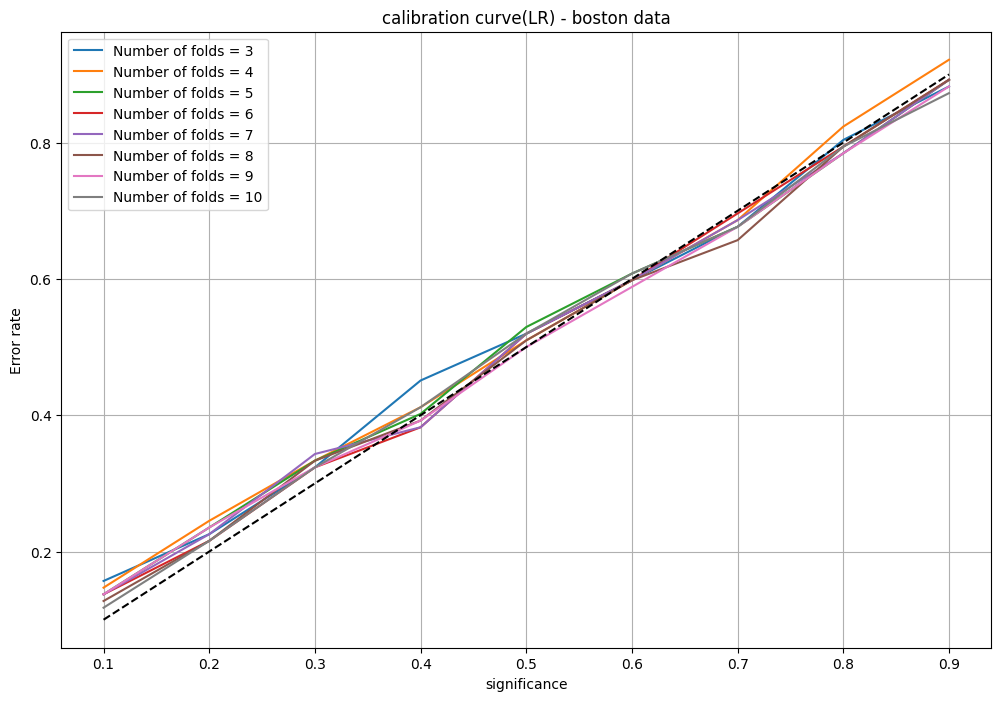

In [24]:
sig = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cv_sets = [3,4,5,6,7,8,9,10]
fig, ax = plt.subplots(figsize=(12, 8))
for j in range(len(cv_sets)):
    coverage = []
    for i in range(len(sig)):
        ccp = Cross_conformal_predictor(sig[i],cv_sets[j],model)
        ccp.train(xtrain,ytrain)
        pred = ccp.predict(xtest)
        coverage.append(ccp.error_rate(pred,ytest))
    ax.plot(sig,coverage,linestyle='-', label = 'Number of folds = '+str(cv_sets[j]))
    ax.set_xlabel('significance')
    ax.set_ylabel('Error rate')
    ax.set_xticks(sig)
    ax.legend()
plt.plot(sig,sig,linestyle="--",color='black')
plt.title('calibration curve(LR) - boston data')
plt.legend()
plt.grid()
plt.savefig('folds-calibrataion(LR).png')
plt.show()

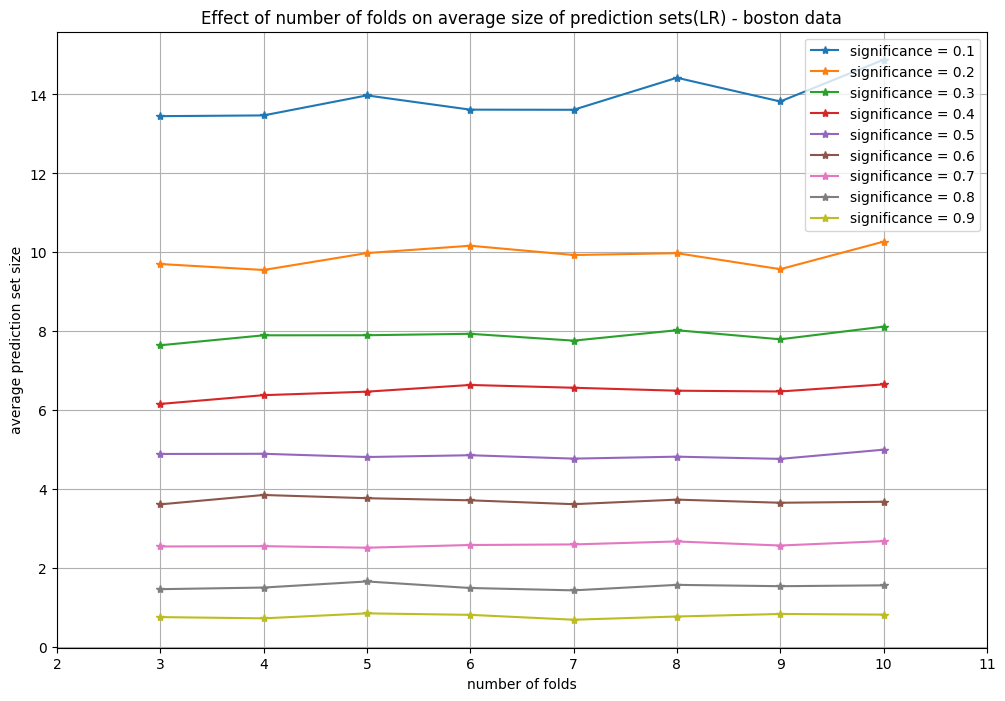

In [25]:
cv_sets = [3,4,5,6,7,8,9,10]
sig = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(12, 8))

for j in range(len(sig)):
    avg_predset_size = []
    for i in range(len(cv_sets)):
        ccp = Cross_conformal_predictor(sig[j],cv_sets[i],model)
        set_ = []
        ccp.train(xtrain,ytrain)
        pred = ccp.predict(xtest)
        for k in range(len(pred)):
            set_.append(pred[k][1]-pred[k][0])
        avg_predset_size.append(np.mean(set_))
    plt.plot(cv_sets,avg_predset_size, marker='*',linestyle='-', label='significance = '+str(sig[j]))
plt.xlabel('number of folds')
plt.ylabel('average prediction set size')
plt.xticks(range(2,12,1))
plt.xlim(2,11)
plt.legend()
plt.title('Effect of number of folds on average size of prediction sets(LR) - boston data')
plt.grid()
plt.savefig('folds_vs_avgpred(LR).png')

plt.show()

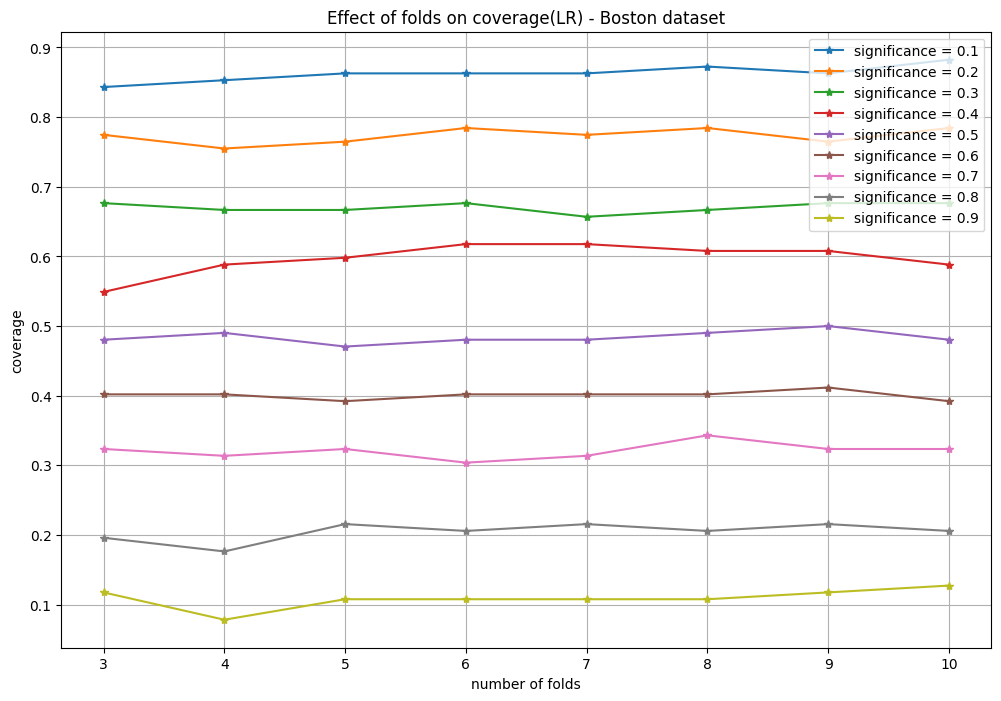

In [26]:
sig = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cv_sets = [3,4,5,6,7,8,9,10]
fig, ax = plt.subplots(figsize=(12, 8))
for j in range(len(sig)):
    coverage = []
    for i in range(len(cv_sets)):
        ccp = Cross_conformal_predictor(sig[j],cv_sets[i],model)
        ccp.train(xtrain,ytrain)
        pred = ccp.predict(xtest)
        coverage.append(1-ccp.error_rate(pred,ytest))
    ax.plot(cv_sets,coverage, marker='*',linestyle='-', label = 'significance = '+str(sig[j]))
ax.set_xlabel('number of folds')
ax.set_ylabel('coverage')
ax.set_xticks(cv_sets)
ax.set_yticks(sig)
plt.title('Effect of folds on coverage(LR) - Boston dataset')
ax.legend()
plt.grid()
plt.savefig('folds-coverage(LR).png')
plt.show()

In [27]:
#Jackknife+
class Cross_conformal_predictor:

    def __init__(self,significance,model):
        self.significance = significance
        self.model = model

    def train(self,train_data,train_labels):
        self.train_data = np.array(train_data)
        self.train_labels = np.array(train_labels)


    def quantile_upper_bound(self):
        k = (1-self.significance)*(len(self.train_data)+1)
        return int(np.ceil(k))

    def quantile_lower_bound(self):
        k = self.significance*(len(self.train_data)+1)
        return int(np.floor(k))


    def predict(self,test_set):

        test_set = np.array(test_set)

        train_set_size = len(self.train_data)

        train_set = []
        train_label = []
        test = []
        predictions = []

        quantile_upper = self.quantile_upper_bound()
        quantile_lower = self.quantile_lower_bound()

        pred = []
        residual = 0
        lower_bound = 0
        upper_bound = 0
        test_sample_lower = [[] for _ in range(len(test_set))]
        test_sample_upper = [[] for _ in range(len(test_set))]


        for j in range(train_set_size):
                    train_set = np.concatenate([self.train_data[:j],self.train_data[j+1:]])
                    train_label = np.concatenate([self.train_labels[:j],self.train_labels[j+1:]])

                    self.model.fit(train_set,train_label)

                    train_pred = self.model.predict(np.expand_dims(self.train_data[j], axis=0))

                    pred = self.model.predict(test_set)

                    residual = abs(train_pred[0]-self.train_labels[j])

                    for i in range(len(test_set)):
                        test_sample_lower[i].append(pred[i]-residual)
                        test_sample_upper[i].append(pred[i]+residual)

        for i in range(len(test_set)):
            test_sample_lower[i] = sorted(test_sample_lower[i])
            test_sample_upper[i] = sorted(test_sample_upper[i])
            lower_bound = test_sample_lower[i][quantile_lower-1]
            upper_bound = test_sample_upper[i][quantile_upper-1]
            predictions.append([lower_bound,upper_bound])

        return predictions

    def error_rate(self,predictions,labels):
        errors = 0
        labels = np.array(labels)
        for i in range(len(labels)):
            if labels[i]>=predictions[i][0] and labels[i]<=predictions[i][1]:
                continue
            else:
                errors += 1
        return errors/len(predictions)



ccp = Cross_conformal_predictor(0.1,model)

set_ = []
ccp.train(xtrain,ytrain)
pred = ccp.predict(xtest)
print('error_rate',ccp.error_rate(pred,ytest))
print(pred)
for i in range(len(pred)):
    set_.append(pred[i][1]-pred[i][0])
print('average prediction set size :',np.mean(set_))

error_rate 0.13725490196078433
[[13.625889251852712, 26.663528091344048], [34.13903640167142, 47.239452791689004], [7.493238395193821, 20.56145180065924], [15.65933200776999, 28.72607644645669], [10.747272457003458, 23.785350375471726], [18.059287736565416, 31.096926576056752], [10.77403186621197, 23.811670705703307], [15.62127580739564, 28.658914646886977], [17.28668615940751, 30.324324998898845], [11.8418142660853, 24.879453105576637], [21.01809380850503, 34.055732647996365], [16.76965747837614, 29.814815445630703], [14.12442828495917, 27.128814745157705], [5.245939562274565, 18.30917478628303], [12.648958539073554, 25.7106829112704], [24.721178119716313, 37.80232103328426], [32.395259987896885, 45.45699958351645], [35.26965274177886, 48.436306016350706], [10.72119087213315, 23.77825684424174], [-0.660588615427411, 12.346901470508477], [13.875167256241504, 26.91280609573284], [12.005909927811238, 25.043548767302575], [13.861082595216999, 26.898721434708335], [19.85503979864874, 32.97

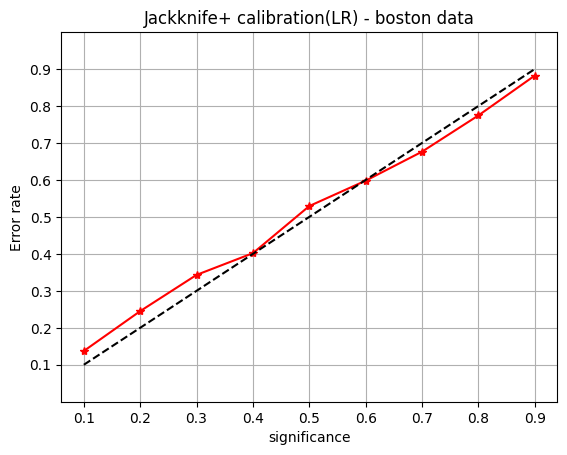

In [28]:
sig = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure()
coverage = []
for i in range(len(sig)):
    ccp = Cross_conformal_predictor(sig[i],model)
    ccp.train(xtrain,ytrain)
    pred = ccp.predict(xtest)
    coverage.append(ccp.error_rate(pred,ytest))

plt.plot(sig,coverage, marker='*',linestyle='-', color='red')
plt.plot(sig,sig,linestyle='--',color='black')
plt.xlabel('significance')
plt.ylabel('Error rate')
plt.title('Jackknife+ calibration(LR) - boston data')
plt.yticks(sig)
plt.ylim(0,1)
plt.grid()
plt.savefig('Jackknife+-calibration(LR).png')
plt.show()